In [1]:
using Plots,DelimitedFiles,Dierckx,Integrals,Cubature,Roots,Unitful

Generic Functions

In [2]:
function FermiDirac(E,μ,kB,Tel)
    return 1/(exp((E-μ)/(kB*Tel))+1)
end

function generate_DOS(File::String,n,FE)
    TotalDOS::Matrix{<:Real}=readdlm(File,skipstart=3)
    return Spline1D(TotalDOS[:,1].+FE,TotalDOS[:,2].*n,bc="nearest")
end

generate_DOS (generic function with 1 method)

Relaxation Times

In [28]:
function current_tauee(τ,E,μ,kB,Tel)
    return τ*μ^2 /((E-μ)^2 +(pi*kB*Tel)^2)
end

function FLT_tauee(rs,E,μ,hbar)
    return 2.5019*rs*(E-μ)^2/hbar
end

FLT_tauee (generic function with 1 method)

Random K-approximation

In [29]:
function matrixelements(DOS,ω,hbar,μ,E)
    return sqrt(3)*pi*hbar*ω/128/μ^2/DOS(E)^3
end

function innerintegral(y,u,p)
    Threads.@threads for i in 1:length(u)
        int(x,p)=p[2](x)*p[2](p[1]+x-u[i])*p[2](u[i])
        prob=IntegralProblem(int,p[3]-p[1]-u[i],p[3])
        y[i]=solve(prob,HCubatureJL(initdiv=2),abstol=1e-4,reltol=1e-4).u
    end
end

function occindependentk(M,hbar,DOS,E,μ)
    p=[E,DOS,μ]
    int = BatchIntegralFunction(innerintegral,zeros(0))
    prob=IntegralProblem(int,(E,μ),p)
    sol=solve(prob,CubatureJLh(),abstol=1e-3,reltol=1e-3)
    return 2*pi/hbar*M
end

occindependentk (generic function with 1 method)

Getting Distriubtions etc.

In [30]:
#= fneqdis = readdlm("fneqdis.txt")

fneq = fneqdis[:,2]
feq = FermiDirac.(egrid,μ,kB,Tel)
ftot = fneq.+feq
ftotspl = Spline1D(egrid,ftot,bc="nearest") =#

Variables

In [31]:
fneqdis = readdlm("MetaVersion/fneqdis.txt")
Tel=300.0
μ=5.53#fneqdis[621,1]
egrid=fneqdis[:,1].-(fneqdis[621,1]-5.53)
kB=8.617e-5
n=59
τ=0.546
hbar=0.6582
h=4.135
rs=1.65
ω=1.323
DOS = generate_DOS("DOS/Au_DOS.dat",n,μ)

Spline1D(knots=[-10.0003,-9.9943 … 19.9937,19.9997] (9999 elements), k=3, extrapolation="nearest", residual=0.0)

Simple Approximations

In [32]:
current=zeros(length(egrid))
FLT=zeros(length(egrid))
for (i,E) in enumerate(egrid)
    current[i]=current_tauee(τ,E,μ,kB,Tel)
    FLT[i]=1/FLT_tauee(rs,E,μ,hbar)
end

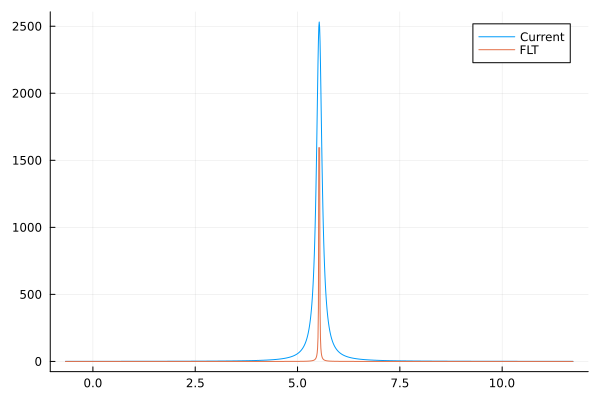

In [33]:
plot(egrid,[current,FLT],label=["Current" "FLT"])

Evaluating Random K Approximation

In [34]:
independentK=zeros(length(egrid))
for (i,E) in enumerate(egrid)
    M = matrixelements(DOS,ω,hbar,μ,E)
    independentK[i]=1/occindependentk(M,hbar,DOS,E,μ)
end

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase C:\Users\u5522838\.julia\packages\SciMLBase\sakPO\src\performance_warnings.jl:33


CompositeException: TaskFailedException

    nested task error: An indexing operation was performed on a NullParameters object. This means no parameters were passed
    into the AbstractSciMLProblem (e.x.: ODEProblem) but the parameters object `p` was used in an indexing
    expression (e.x. `p[i]`, or `x .+ p`). Two common reasons for this issue are:
    
    1. Forgetting to pass parameters into the problem constructor. For example, `ODEProblem(f,u0,tspan)` should
    be `ODEProblem(f,u0,tspan,p)` in order to use parameters.
    
    2. Using the wrong function signature. For example, with `ODEProblem`s the function signature is always
    `f(du,u,p,t)` for the in-place form or `f(u,p,t)` for the out-of-place form. Note that the `p` argument
    will always be in the function signature regardless of if the problem is defined with parameters!
    
    
    Stacktrace:
      [1] getindex(::SciMLBase.NullParameters, i::Int64)
        @ SciMLBase C:\Users\u5522838\.julia\packages\SciMLBase\sakPO\src\problems\problem_utils.jl:166
      [2] (::var"#int#93"{Int64, Vector{Float64}})(x::Float64, p::SciMLBase.NullParameters)
        @ Main c:\Users\u5522838\OneDrive\PhD\LightMatter.jl\RelaxationTime.ipynb:7
      [3] (::IntegralFunction{false, SciMLBase.FullSpecialize, var"#int#93"{Int64, Vector{Float64}}, Nothing})(::Float64, ::Vararg{Any})
        @ SciMLBase C:\Users\u5522838\.julia\packages\SciMLBase\sakPO\src\scimlfunctions.jl:2299
      [4] (::Integrals.var"#62#64"{IntegralProblem{false, SciMLBase.NullParameters, IntegralFunction{false, SciMLBase.FullSpecialize, var"#int#93"{Int64, Vector{Float64}}, Nothing}, Tuple{Float64, Float64}, @Kwargs{}}})(x::Float64)
        @ Integrals C:\Users\u5522838\.julia\packages\Integrals\tvunm\src\Integrals.jl:160
      [5] (::HCubature.var"#6#7"{Integrals.var"#62#64"{IntegralProblem{false, SciMLBase.NullParameters, IntegralFunction{false, SciMLBase.FullSpecialize, var"#int#93"{Int64, Vector{Float64}}, Nothing}, Tuple{Float64, Float64}, @Kwargs{}}}})(x::StaticArraysCore.SVector{1, Float64})
        @ HCubature C:\Users\u5522838\.julia\packages\HCubature\gOo1d\src\HCubature.jl:257
      [6] (::HCubature.GaussKronrod{Float64})(f::HCubature.var"#6#7"{Integrals.var"#62#64"{IntegralProblem{false, SciMLBase.NullParameters, IntegralFunction{false, SciMLBase.FullSpecialize, var"#int#93"{Int64, Vector{Float64}}, Nothing}, Tuple{Float64, Float64}, @Kwargs{}}}}, a_::StaticArraysCore.SVector{1, Float64}, b_::StaticArraysCore.SVector{1, Float64}, norm::typeof(LinearAlgebra.norm))
        @ HCubature C:\Users\u5522838\.julia\packages\HCubature\gOo1d\src\gauss-kronrod.jl:32
      [7] hcubature_(f::HCubature.var"#6#7"{Integrals.var"#62#64"{IntegralProblem{false, SciMLBase.NullParameters, IntegralFunction{false, SciMLBase.FullSpecialize, var"#int#93"{Int64, Vector{Float64}}, Nothing}, Tuple{Float64, Float64}, @Kwargs{}}}}, a::StaticArraysCore.SVector{1, Float64}, b::StaticArraysCore.SVector{1, Float64}, norm::typeof(LinearAlgebra.norm), rtol_::Float64, atol::Float64, maxevals::Int64, initdiv::Int64, buf::Nothing)
        @ HCubature C:\Users\u5522838\.julia\packages\HCubature\gOo1d\src\HCubature.jl:110
      [8] hquadrature(f::Integrals.var"#62#64"{IntegralProblem{false, SciMLBase.NullParameters, IntegralFunction{false, SciMLBase.FullSpecialize, var"#int#93"{Int64, Vector{Float64}}, Nothing}, Tuple{Float64, Float64}, @Kwargs{}}}, a::Float64, b::Float64; norm::Function, rtol::Float64, atol::Float64, maxevals::Int64, initdiv::Int64, buffer::Nothing)
        @ HCubature C:\Users\u5522838\.julia\packages\HCubature\gOo1d\src\HCubature.jl:257
      [9] __solvebp_call(prob::IntegralProblem{false, SciMLBase.NullParameters, IntegralFunction{false, SciMLBase.FullSpecialize, var"#int#93"{Int64, Vector{Float64}}, Nothing}, Tuple{Float64, Float64}, @Kwargs{}}, alg::HCubatureJL{typeof(LinearAlgebra.norm)}, sensealg::Integrals.ReCallVJP{Integrals.ZygoteVJP}, domain::Tuple{Float64, Float64}, p::SciMLBase.NullParameters; reltol::Float64, abstol::Float64, maxiters::Int64)
        @ Integrals C:\Users\u5522838\.julia\packages\Integrals\tvunm\src\Integrals.jl:164
     [10] __solvebp_call(::Integrals.IntegralCache{false, IntegralFunction{false, SciMLBase.FullSpecialize, var"#int#93"{Int64, Vector{Float64}}, Nothing}, Tuple{Float64, Float64}, SciMLBase.NullParameters, @Kwargs{}, HCubatureJL{typeof(LinearAlgebra.norm)}, Integrals.ReCallVJP{Integrals.ZygoteVJP}, @Kwargs{abstol::Float64, reltol::Float64}, Nothing}, ::HCubatureJL{typeof(LinearAlgebra.norm)}, ::Vararg{Any}; kwargs::@Kwargs{abstol::Float64, reltol::Float64})
        @ Integrals C:\Users\u5522838\.julia\packages\Integrals\tvunm\src\common.jl:115
     [11] __solvebp(::Integrals.IntegralCache{false, IntegralFunction{false, SciMLBase.FullSpecialize, var"#int#93"{Int64, Vector{Float64}}, Nothing}, Tuple{Float64, Float64}, SciMLBase.NullParameters, @Kwargs{}, HCubatureJL{typeof(LinearAlgebra.norm)}, Integrals.ReCallVJP{Integrals.ZygoteVJP}, @Kwargs{abstol::Float64, reltol::Float64}, Nothing}, ::Vararg{Any}; kwargs::@Kwargs{abstol::Float64, reltol::Float64})
        @ Integrals C:\Users\u5522838\.julia\packages\Integrals\tvunm\src\Integrals.jl:67
     [12] solve!(cache::Integrals.IntegralCache{false, IntegralFunction{false, SciMLBase.FullSpecialize, var"#int#93"{Int64, Vector{Float64}}, Nothing}, Tuple{Float64, Float64}, SciMLBase.NullParameters, @Kwargs{}, HCubatureJL{typeof(LinearAlgebra.norm)}, Integrals.ReCallVJP{Integrals.ZygoteVJP}, @Kwargs{abstol::Float64, reltol::Float64}, Nothing})
        @ Integrals C:\Users\u5522838\.julia\packages\Integrals\tvunm\src\common.jl:105
     [13] solve(prob::IntegralProblem{false, SciMLBase.NullParameters, IntegralFunction{false, SciMLBase.FullSpecialize, var"#int#93"{Int64, Vector{Float64}}, Nothing}, Tuple{Float64, Float64}, @Kwargs{}}, alg::HCubatureJL{typeof(LinearAlgebra.norm)}; kwargs::@Kwargs{abstol::Float64, reltol::Float64})
        @ Integrals C:\Users\u5522838\.julia\packages\Integrals\tvunm\src\common.jl:101
     [14] macro expansion
        @ c:\Users\u5522838\OneDrive\PhD\LightMatter.jl\RelaxationTime.ipynb:9 [inlined]
     [15] (::var"#255#threadsfor_fun#91"{var"#255#threadsfor_fun#90#92"{Vector{Float64}, Vector{Float64}, Vector{Any}, UnitRange{Int64}}})(tid::Int64; onethread::Bool)
        @ Main .\threadingconstructs.jl:215
     [16] #255#threadsfor_fun
        @ .\threadingconstructs.jl:182 [inlined]
     [17] (::Base.Threads.var"#1#2"{var"#255#threadsfor_fun#91"{var"#255#threadsfor_fun#90#92"{Vector{Float64}, Vector{Float64}, Vector{Any}, UnitRange{Int64}}}, Int64})()
        @ Base.Threads .\threadingconstructs.jl:154

...and 11 more exceptions.


In [35]:
plot(egrid[650:end],[current,FLT,SimpleK],label=["Current" "FLT" "Simple K"])

UndefVarError: UndefVarError: `SimpleK` not defined

In [37]:
function FermiDirac(E::Float64,μ::Float64,Tel)::Float64
    return 1/(exp((E-μ)/(kB*Tel))+1)
end

function NumberOfElectrons(μ::Float64,Tel::Float64,DOS)::Float64
    int(u,p)=DOS(u)*FermiDirac(u,μ,Tel)
    prob=IntegralProblem(int,-Inf,μ+10)
    sol=solve(prob,HCubatureJL(initdiv=2);reltol=1e-10,abstol=1e-10)
    return sol.u
end

function ChemicalPotential(Tel,DOS,nopart)
    x0=11.7
    f(x)=nopart-NumberOfElectrons(x,Tel,DOS)
    prob=ZeroProblem(f,x0)
    return solve(prob,Order1();atol=1e-3,rtol=1e-3)
end

function dFDdE(kB::Float64,Tel::Real,μ::Float64,E::Float64)::Real
    Numer=-exp((E-μ)/(kB*Tel))
    Denom=kB*Tel*(exp((E-μ)/(kB*Tel))+1)^2
    return Numer/Denom
end

function nonlinear_electronphononcoupling(hbar::Real,kB::Real,λ::Real,DOS::Spline1D,Tel::Real,μ::Real,FE::Real)
    prefac=pi*kB*λ/DOS(FE)/hbar
    p=(kB,Tel,μ,DOS)
    int(u,p) = electronphononcoupling_int(u,p)
    g=prefac.*solve(IntegralProblem(int,(μ-(12*Tel/10000),μ+(12*Tel/10000)),p),HCubatureJL(initdiv=50);reltol=1e-4,abstol=1e-4).u
    return -g#-g*(Tel-Tph)
end

function electronphononcoupling_int(u::Real,p::Tuple{Real,Real,Real,Spline1D})
    return p[4](u)^2*dFDdE(p[1],p[2],p[3],u)
end

function nonlinear_electronheatcapacity(kB::Real,Tel::Real,μ::Real,DOS::Spline1D)
    p=(kB,Tel,μ,DOS)
    int(u,p) = electronheatcapacity_int(u,p)
    return solve(IntegralProblem(int,(μ-(6*Tel/10000),μ+(6*Tel/10000)),p),HCubatureJL(initdiv=50);reltol=1e-3,abstol=1e-3).u
end

function electronheatcapacity_int(u::Real,p::Tuple{Real,Real,Real,Spline1D})
    return dFDdT(p[1],p[2],p[3],u)*p[4](u)*u
end

function dFDdT(kB::Float64,Tel::Real,μ::Float64,E::Float64)::Real
    Numer=(E-μ)*exp((E-μ)/(kB*Tel))
    Denom=kB*Tel^2*(exp((E-μ)/(kB*Tel))+1)^2
    return Numer/Denom
end

n=60.3
ne=3
DOS = generate_DOS("DOS/Al_DOS.dat",n,11.7)
kB=8.617e-5
hbar=0.6582

DOSne = NumberOfElectrons(11.7,1e-18,DOS)
λ=185.9e-6
TRange=range(1.0,20000.0,step=20)
cp = zeros(length(TRange))
gep = zeros(length(TRange))
Threads.@threads for i in eachindex(TRange)
    cp[i]=ChemicalPotential(TRange[i],DOS,DOSne)
    gep[i]=nonlinear_electronphononcoupling(hbar,kB,λ,DOS,TRange[i],cp[i],11.7)
    #gep[i]=nonlinear_electronheatcapacity(kB,TRange[i],cp[i],DOS)
end

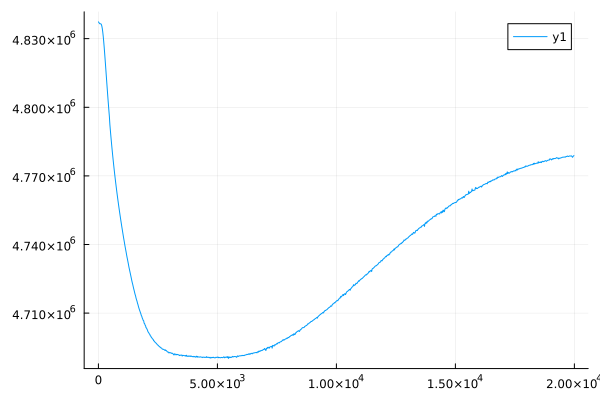

In [39]:
gep = ustrip.(uconvert.(u"W/m^3/K",gep./1e17.*u"eV/fs/nm^3/K"))
#gep = ustrip.(uconvert.(u"J/m^3/K",gep./1e5.*u"eV/nm^3/K"))
plot(TRange,gep)

In [51]:
io=open("Au_gep.csv","w")
output=hcat(TRange,gep)
for row in eachrow(output)
    println(io,join(row, " "))
end
close(io)

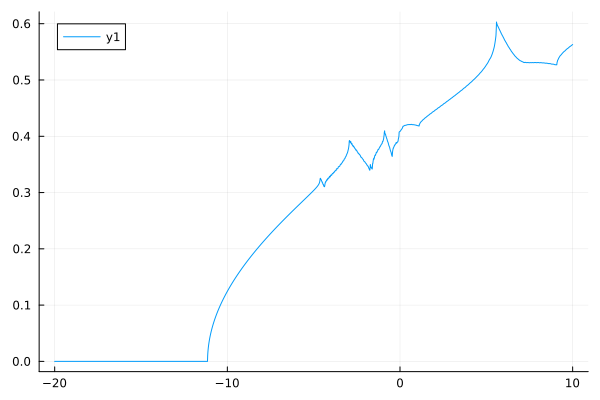

In [62]:
ERange=range(-20,10,step=0.01)
plot(ERange,DOS.(ERange)./(n*ne))